# Time seris prediction(water demand) with pyramid-arima

pyramid-arima 的安装请见 https://pypi.org/project/pyramid-arima/

$ pip install pyramid-arima

函数参数介绍请见 https://www.alkaline-ml.com/pmdarima/index.html

Github上的例子请见 https://github.com/tgsmith61591/pmdarima



In [1]:
import os
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'pmdarima'

## 读取数据并作图看一下

In [3]:
root_1 = '../流量'
df = pd.read_csv(os.path.join(root_1, '3bs_8q_4p_dataset_washed.csv'),
                parse_dates=['datetime'],
#                 index_col='timestamp'
                )

FileNotFoundError: [Errno 2] File b'../\xe6\xb5\x81\xe9\x87\x8f\\3bs_8q_4p_dataset_washed.csv' does not exist: b'../\xe6\xb5\x81\xe9\x87\x8f\\3bs_8q_4p_dataset_washed.csv'

In [3]:
df.head(3)

,datetime,timestamp,q1,p1,p2,q2,q3,p3,q4,q5,q6,q7,q8,q9,q10,q11,p4,p5,p6,p7
0,2017-05-05 18:00:00,1493978400,408.0,0.28,0.29,411.0,2252.5,0.31,287.0,162.0,245.0,108.0,222.0,473.0,492.0,74.0,0.272444,0.273333,0.25,0.266200
1,2017-05-05 18:15:00,1493979300,406.0,0.29,0.29,409.0,2247.5,0.31,288.0,173.0,254.0,111.0,225.0,472.0,496.0,75.0,0.274000,0.275556,0.25,0.268143
2,2017-05-05 18:30:00,1493980200,402.0,0.29,0.29,406.0,2250.0,0.31,284.0,169.0,250.0,115.0,223.0,494.0,491.0,76.0,0.273286,0.276000,0.25,0.267250


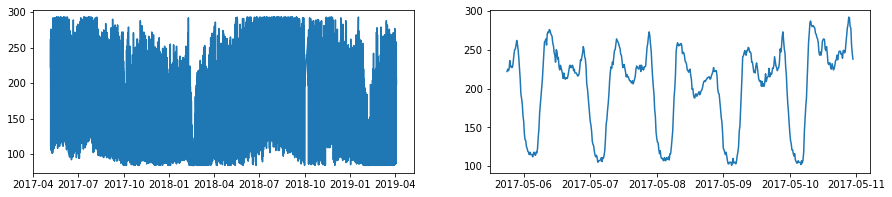

In [4]:
# 我们所研究的列是'q8'
station_for_pred = 'q8'
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(df['datetime'], df[station_for_pred])
plt.subplot(122)
plt.plot(df['datetime'].iloc[:500], df[station_for_pred].iloc[:500])
plt.show()

## 以2019年为分割点，建立训练集、测试集

In [5]:
split_point = datetime.timestamp(datetime(2019,1,1))
df_train = df[df['timestamp'] < split_point]
df_test = df[df['timestamp'] > split_point]
data_train = df_train[station_for_pred].values
data_test = df_test[station_for_pred].values

In [6]:
len(data_train)

58104

## 训练Arima模型

In [7]:
# 预训练，用1/4的数据训练模型 p d q 的值的大概范围
model = pm.auto_arima(data_train[: int(len(data_train)/4)], 
                      error_action='ignore',
#                       max_p=4,
#                       max_q=4,
                      seasonal=True, 
                      m=12,
                      trace=True,
                      stepwise=True)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=94574.684, BIC=94635.353, Fit time=25.806 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=102829.953, BIC=102845.120, Fit time=0.383 seconds


KeyboardInterrupt: 

### ARIMA 模型，model.order = [p, d, q]

 * p--代表预测模型中采用的时序数据本身的滞后数(lags) ,也叫做AR/Auto-Regressive项

 * d--代表时序数据需要进行几阶差分化，才是稳定的，也叫Integrated项

 * q--代表预测模型中采用的预测误差的滞后数(lags)，也叫做MA/Moving Average项


参考 https://blog.csdn.net/HHXUN/article/details/79858672

In [7]:
model.order
# 2,1,4

NameError: name 'model' is not defined

In [9]:
model.seasonal_order
2,0,2,12

(2, 0, 2, 12)

In [7]:
# model_2 = pm.auto_arima(data_train, error_action='ignore',
#                         d = model.order[1],
#                         start_p=2,
#                         max_p=2,
#                         start_q=4,
#                         max_q=4,
#                         seasonal=True, 
#                         m=12,
#                         trace=True,
#                         stepwise=True)

In [ ]:
# model_3 = pm.ARIMA(model.order,
#                   seasonal_order=model.seasonal_order
#                   )
model_3 = pm.ARIMA((2,1,4),
                  seasonal_order=(2,0,2,12)
                  )
model_3.fit(data_train)

## 在测试集上评价模型

In [ ]:
timestep_for_pred = 4*2 #数据是每十五分钟一个，预测两个小时后，即8个点以后
pred_list = []
for yi in tqdm(data_test):
    # 每次预测 15min - 2h 之间的8个点，保留最后一个点
    pred_list += [model_3.predict(n_periods=timestep_for_pred)[-1]]
    # 更新模型
    model_3.update(yi)    

In [ ]:
df_test['pred_arima'] = pred_list
df_test['pred_arima'] = df_test.shift(timestep_for_pred)
df_test = df_test.iloc[:, timestep_for_pred:]

## 从保存的文档里读取数据

In [3]:
df_test = pd.read_csv('./arima_result2.csv', index_col=0, parse_dates=['datetime'])

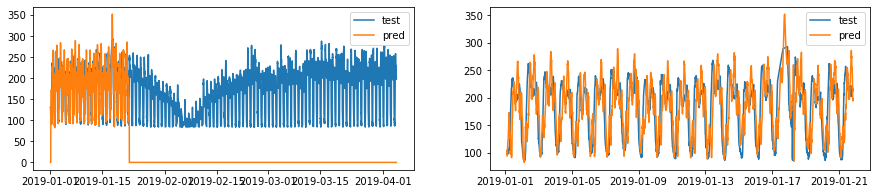

In [27]:
station_for_pred = 'q8'
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(df_test['datetime'], df_test[station_for_pred])
plt.plot(df_test['datetime'], df_test['pred_arima'])
plt.legend(['test', 'pred'])
plt.subplot(122)
start = 10
size = 2000
plt.plot(df_test['datetime'].iloc[start: size], df_test[station_for_pred].iloc[start: size])
plt.plot(df_test['datetime'].iloc[start: size], df_test['pred_arima'].iloc[start: size])
plt.legend(['test', 'pred'])
plt.savefig('../result/figures/arima_baseline.png',format='png',dpi=1000)
plt.show()

## 评价指标 MSE，MAE，MAPE 

In [41]:
from sklearn import metrics
from sklearn import preprocessing
def eval_metrics(y_true, y_pred):
    metrics_dict = dict()
    metrics_dict['MAE'] = metrics.mean_absolute_error(y_true, y_pred)
    metrics_dict['MSE'] = metrics.mean_squared_error(y_true, y_pred)
    metrics_dict['MAPE'] = np.mean(np.true_divide(np.abs(y_true-y_pred), y_true))
    return metrics_dict
def normalize(x):
     # Create a minimum and maximum processor object
    x = x.reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()

    # Create an object to transform the data to fit minmax processor
    x_scaled = min_max_scaler.fit_transform(x)
    return x_scaled

In [42]:
y_true = df_test[station_for_pred].iloc[start: size].values
y_true_nor = normalize(y_true)
y_pred = df_test['pred_arima'].iloc[start: size].values
y_pred_nor = normalize(y_pred)

In [43]:
eval_dict = eval_metrics(y_true_nor, y_pred_nor)

G:\Anaconda\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [44]:
eval_dict

{'MAE': 0.17726765302351266, 'MSE': 0.05439766469621332, 'MAPE': inf}